In [1]:
import pandas as pd
import numpy as np
# import torch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn import preprocessing

seed = 42

FILENAME = "train_dataset.csv"

#Prepare train data
df1 = pd.read_csv(FILENAME, encoding='ISO-8859-1', sep=",", low_memory=False)
# print("EX1) #Righe: " + str(df1.shape[0])+ " #Colonne: "+str(df1.shape[1]))

# print(df1.nunique())
# print(df1.isna().sum())

# print(df1.shape)
df1 = df1.dropna()
# print(df1.shape)

In [3]:
y = df1["type"]
X = df1.drop(columns=["type", "label"])

err_arr = X.loc[X["src_bytes"] == "0.0.0.0"]
X = X.drop(index=err_arr.index)
y = y.drop(index=err_arr.index)
X.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

X = X.to_numpy()
y = y.to_numpy()

for feature in ["dns_AA","dns_RD","dns_RA","dns_rejected","ssl_version","ssl_cipher","ssl_resumed","ssl_established","ssl_subject","ssl_issuer","http_trans_depth","http_method","http_uri","http_referrer","http_version","http_request_body_len","http_response_body_len","http_status_code","http_user_agent","http_orig_mime_types","http_resp_mime_types","weird_name","weird_addl","weird_notice"]:
    # print(f"Feature: {feature}")    
    feature_index = np.where(df1.columns == feature)[0][0]
    elements, counts = np.unique(X[:, feature_index], return_counts=True)

    for element, count in zip(elements, counts):
        print(f"    Element: {element}, Count: {count}")

    Element: -, Count: 571298
    Element: F, Count: 44720
    Element: T, Count: 965
    Element: -, Count: 571298
    Element: F, Count: 3384
    Element: T, Count: 42301
    Element: -, Count: 571298
    Element: F, Count: 24978
    Element: T, Count: 20707
    Element: -, Count: 571298
    Element: F, Count: 25403
    Element: T, Count: 20282
    Element: -, Count: 616307
    Element: TLSv10, Count: 655
    Element: TLSv11, Count: 1
    Element: TLSv12, Count: 12
    Element: TLSv13, Count: 8
    Element: -, Count: 616307
    Element: TLS_AES_128_GCM_SHA256, Count: 8
    Element: TLS_DHE_RSA_WITH_AES_128_CBC_SHA, Count: 1
    Element: TLS_DHE_RSA_WITH_AES_256_CBC_SHA, Count: 1
    Element: TLS_ECDHE_RSA_WITH_AES_128_GCM_SHA256, Count: 10
    Element: TLS_ECDHE_RSA_WITH_AES_256_CBC_SHA, Count: 655
    Element: TLS_ECDHE_RSA_WITH_AES_256_GCM_SHA384, Count: 1
    Element: -, Count: 616274
    Element: F, Count: 704
    Element: T, Count: 5
    Element: -, Count: 616274
    Element: F,

In [4]:
oe = preprocessing.OrdinalEncoder()
oe.fit(X)
X = oe.transform(X)

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

In [5]:
x_tomod = X

In [6]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(0.01)
x_tomod = selector.fit_transform(x_tomod)

In [7]:
print(x_tomod.shape, y.shape)

(616983, 28) (616983,)


In [8]:
X = x_tomod

In [9]:
train_idx, test_idx = train_test_split(np.arange(X.shape[0]), test_size=0.2, stratify=y, random_state=seed)
test_idx, val_idx = train_test_split(test_idx, test_size=0.5, stratify=y[test_idx], random_state=seed)

X_test = X[test_idx,:]
y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]

In [10]:
## Scaling
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

## PCA
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)

## LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=9)
lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)
X_val_lda = lda.transform(X_val)

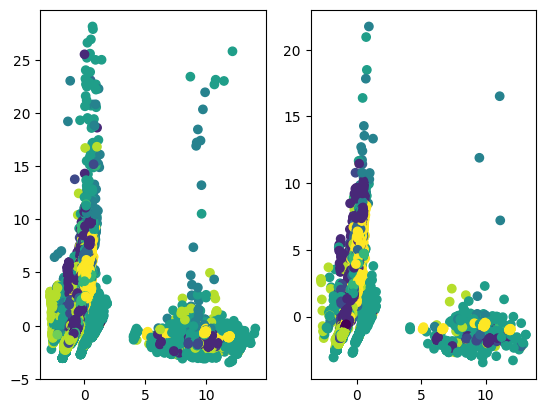

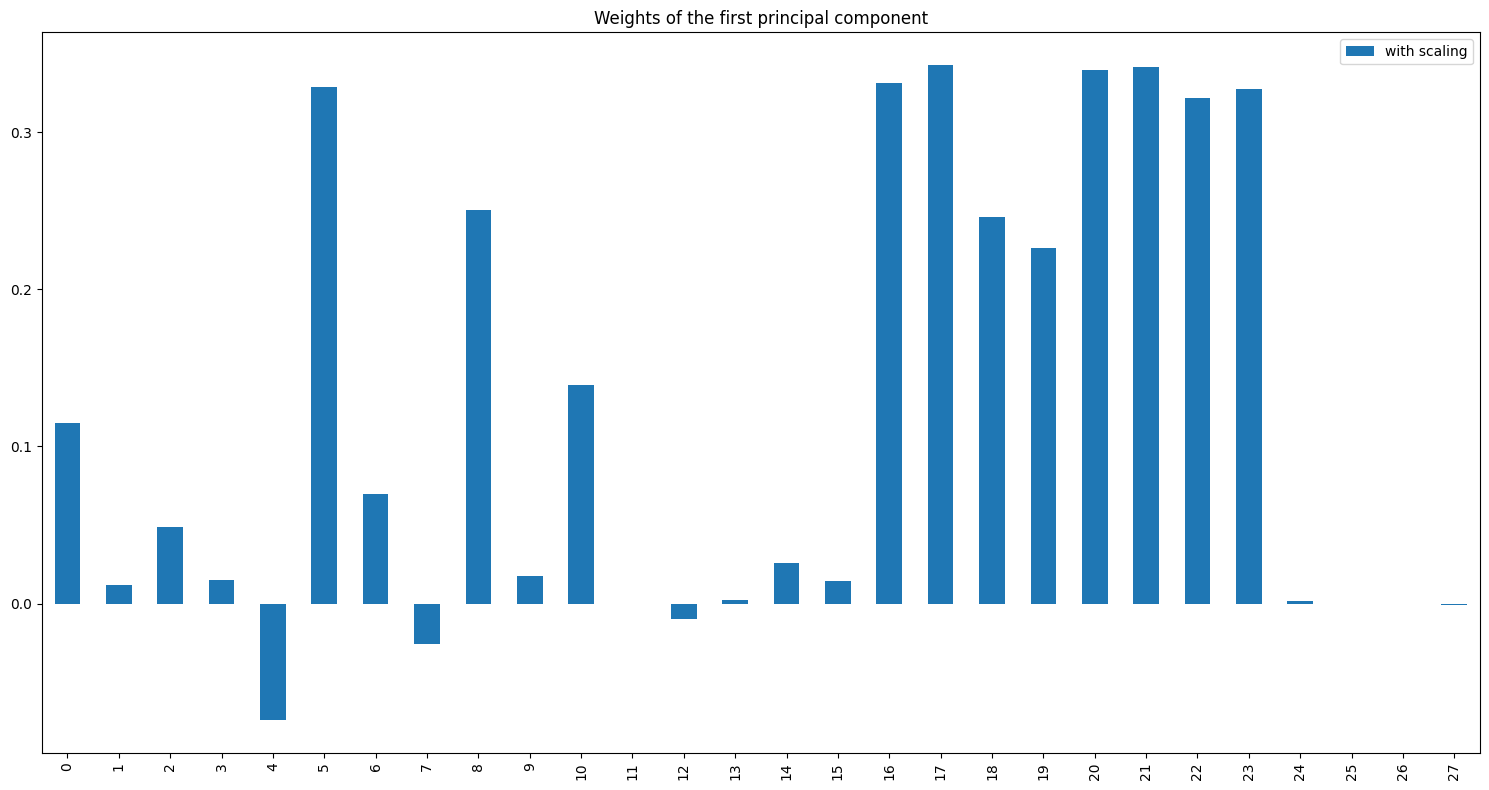

In [11]:
## PCA plotting
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)

axs[0].scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train)
axs[1].scatter(X_val_pca[:,0], X_val_pca[:,1], c=y_val)
plt.show()

first_pca_component = pd.DataFrame()
first_pca_component["with scaling"] = pca.components_[0]
first_pca_component.plot.bar(title="Weights of the first principal component", figsize=(15, 8))
_ = plt.tight_layout()

In [12]:
import pickle

file = pickle.load(open("knn.pkl", "rb"))

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score

---

In [14]:
## WITH PCA

list_clf_pca = []
list_acc_train_pca = []
list_rec_train_pca = []
list_pre_train_pca = []
list_f1_train_pca = []

for k in [10,20,50,100,500,775,900,1000,1500,2000]:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train_pca, y_train)

    y_pred = clf.predict(X_test_pca)
    score_acc = accuracy_score(y_test, y_pred)
    list_acc_train_pca.append(score_acc)
    score_recall = recall_score(y_test, y_pred, average='weighted')
    list_rec_train_pca.append(score_recall)
    score_precision = precision_score(y_test, y_pred, average='weighted')
    list_pre_train_pca.append(score_precision)
    score_f1 = f1_score(y_test, y_pred, average='weighted')
    list_f1_train_pca.append(score_f1)

    score = clf.score(X_test_pca, y_test)

    print("K={:d}".format(k))
    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

    # if best_score < score:
    #     best_score = score
    #     best_k = k
    #     best_clf = clf
    
    list_clf_pca.append(clf)

K=10
  Accuracy - 0.9974
  F1 - 0.9974
K=20
  Accuracy - 0.9968
  F1 - 0.9968
K=50
  Accuracy - 0.9946
  F1 - 0.9946
K=100
  Accuracy - 0.9928
  F1 - 0.9927
K=500
  Accuracy - 0.9806
  F1 - 0.9801


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=775
  Accuracy - 0.9746
  F1 - 0.9735


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=900
  Accuracy - 0.9720
  F1 - 0.9708


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1000
  Accuracy - 0.9697
  F1 - 0.9683


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1500
  Accuracy - 0.9641
  F1 - 0.9620


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=2000
  Accuracy - 0.9534
  F1 - 0.9507


In [15]:

# file = pickle.load(open("knn_pca.pkl", "rb"))

# list_clf_pca = file[0]

list_acc_val_pca = []
list_rec_val_pca = []
list_pre_val_pca = []
list_f1_val_pca = []

for clf in list_clf_pca:
    val_pred = clf.predict(X_val_pca)

    score_acc = accuracy_score(y_val, val_pred)
    list_acc_val_pca.append(score_acc)
    score_recall = recall_score(y_val, val_pred, average='weighted')
    list_rec_val_pca.append(score_recall)
    score_precision = precision_score(y_val, val_pred, average='weighted')
    list_pre_val_pca.append(score_precision)
    score_f1 = f1_score(y_val, val_pred, average='weighted')
    list_f1_val_pca.append(score_f1)

    print(clf.n_neighbors)

    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

10
  Accuracy - 0.9969
  F1 - 0.9969
20
  Accuracy - 0.9962
  F1 - 0.9962
50
  Accuracy - 0.9940
  F1 - 0.9940
100
  Accuracy - 0.9924
  F1 - 0.9923
500
  Accuracy - 0.9798
  F1 - 0.9792


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


775
  Accuracy - 0.9728
  F1 - 0.9716


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


900
  Accuracy - 0.9703
  F1 - 0.9690


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1000
  Accuracy - 0.9681
  F1 - 0.9666


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1500
  Accuracy - 0.9625
  F1 - 0.9603
2000
  Accuracy - 0.9521
  F1 - 0.9491


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---

In [16]:
list_clf_lda = []
list_acc_train_lda = []
list_rec_train_lda = []
list_pre_train_lda = []
list_f1_train_lda = []

for k in [10,20,50,100,500,775,900,1000,1500,2000]:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train_lda, y_train)

    y_pred = clf.predict(X_test_lda)
    score_acc = accuracy_score(y_test, y_pred)
    list_acc_train_pca.append(score_acc)
    score_recall = recall_score(y_test, y_pred, average='weighted')
    list_rec_train_pca.append(score_recall)
    score_precision = precision_score(y_test, y_pred, average='weighted')
    list_pre_train_pca.append(score_precision)
    score_f1 = f1_score(y_test, y_pred, average='weighted')
    list_f1_train_pca.append(score_f1)

    score = clf.score(X_test_lda, y_test)

    print("K={:d}".format(k))
    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

    # if best_score < score:
    #     best_score = score
    #     best_k = k
    #     best_clf = clf
    
    list_clf_lda.append(clf)

K=10
  Accuracy - 0.9976
  F1 - 0.9975
K=20
  Accuracy - 0.9966
  F1 - 0.9966
K=50
  Accuracy - 0.9950
  F1 - 0.9949
K=100
  Accuracy - 0.9929
  F1 - 0.9928
K=500
  Accuracy - 0.9843
  F1 - 0.9839
K=775
  Accuracy - 0.9789
  F1 - 0.9783
K=900
  Accuracy - 0.9774
  F1 - 0.9765
K=1000
  Accuracy - 0.9762
  F1 - 0.9749


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1500
  Accuracy - 0.9700
  F1 - 0.9680


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=2000
  Accuracy - 0.9648
  F1 - 0.9625


In [17]:

# file = pickle.load(open("knn_pca.pkl", "rb"))

# list_clf_pca = file[0]

list_acc_val_lda = []
list_rec_val_lda = []
list_pre_val_lda = []
list_f1_val_lda = []

for clf in list_clf_lda:
    val_pred = clf.predict(X_val_lda)

    score_acc = accuracy_score(y_val, val_pred)
    list_acc_val_pca.append(score_acc)
    score_recall = recall_score(y_val, val_pred, average='weighted')
    list_rec_val_pca.append(score_recall)
    score_precision = precision_score(y_val, val_pred, average='weighted')
    list_pre_val_pca.append(score_precision)
    score_f1 = f1_score(y_val, val_pred, average='weighted')
    list_f1_val_pca.append(score_f1)

    print(clf.n_neighbors)

    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

10
  Accuracy - 0.9973
  F1 - 0.9973
20
  Accuracy - 0.9961
  F1 - 0.9961
50
  Accuracy - 0.9944
  F1 - 0.9943
100
  Accuracy - 0.9923
  F1 - 0.9922
500
  Accuracy - 0.9825
  F1 - 0.9821
775
  Accuracy - 0.9777
  F1 - 0.9771
900
  Accuracy - 0.9759
  F1 - 0.9750
1000
  Accuracy - 0.9747
  F1 - 0.9733


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1500
  Accuracy - 0.9690
  F1 - 0.9668
2000
  Accuracy - 0.9635
  F1 - 0.9611


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---

In [18]:
list_clf = []
list_acc_train = []
list_rec_train = []
list_pre_train = []
list_f1_train = []

for k in [10,20,50,100,500,775,900,1000,1500,2000]:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    score_acc = accuracy_score(y_test, y_pred)
    list_acc_train_pca.append(score_acc)
    score_recall = recall_score(y_test, y_pred, average='weighted')
    list_rec_train_pca.append(score_recall)
    score_precision = precision_score(y_test, y_pred, average='weighted')
    list_pre_train_pca.append(score_precision)
    score_f1 = f1_score(y_test, y_pred, average='weighted')
    list_f1_train_pca.append(score_f1)

    score = clf.score(X_test, y_test)

    print("K={:d}".format(k))
    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

    # if best_score < score:
    #     best_score = score
    #     best_k = k
    #     best_clf = clf
    
    list_clf.append(clf)

K=10
  Accuracy - 0.9974
  F1 - 0.9974
K=20
  Accuracy - 0.9968
  F1 - 0.9968
K=50
  Accuracy - 0.9946
  F1 - 0.9946
K=100
  Accuracy - 0.9928
  F1 - 0.9927
K=500
  Accuracy - 0.9806
  F1 - 0.9801


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=775
  Accuracy - 0.9746
  F1 - 0.9735


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=900
  Accuracy - 0.9720
  F1 - 0.9708


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1000
  Accuracy - 0.9697
  F1 - 0.9683


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1500
  Accuracy - 0.9641
  F1 - 0.9620


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=2000
  Accuracy - 0.9534
  F1 - 0.9507


In [19]:

# file = pickle.load(open("knn_pca.pkl", "rb"))

# list_clf_pca = file[0]

list_acc_val = []
list_rec_val = []
list_pre_val = []
list_f1_val = []

for clf in list_clf:
    val_pred = clf.predict(X_val)

    score_acc = accuracy_score(y_val, val_pred)
    list_acc_val_pca.append(score_acc)
    score_recall = recall_score(y_val, val_pred, average='weighted')
    list_rec_val_pca.append(score_recall)
    score_precision = precision_score(y_val, val_pred, average='weighted')
    list_pre_val_pca.append(score_precision)
    score_f1 = f1_score(y_val, val_pred, average='weighted')
    list_f1_val_pca.append(score_f1)

    print(clf.n_neighbors)

    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

10
  Accuracy - 0.9969
  F1 - 0.9969
20
  Accuracy - 0.9962
  F1 - 0.9962
50
  Accuracy - 0.9940
  F1 - 0.9940
100
  Accuracy - 0.9924
  F1 - 0.9923
500
  Accuracy - 0.9798
  F1 - 0.9792


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


775
  Accuracy - 0.9728
  F1 - 0.9716


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


900
  Accuracy - 0.9703
  F1 - 0.9690


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1000
  Accuracy - 0.9681
  F1 - 0.9666


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1500
  Accuracy - 0.9625
  F1 - 0.9603
2000
  Accuracy - 0.9521
  F1 - 0.9491


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
with open('knn_lda_red.pkl', 'wb') as f:
    pickle.dump([list_clf_lda, list_acc_train_lda, list_rec_train_lda, list_pre_train_lda, list_f1_train_lda, list_acc_val_lda, list_rec_val_lda, list_pre_val_lda, list_f1_val_lda], f)
with open('knn_pca_red.pkl', 'wb') as f:
    pickle.dump([list_clf_pca, list_acc_train_pca, list_rec_train_pca, list_pre_train_pca, list_f1_train_pca, list_acc_val_pca, list_rec_val_pca, list_pre_val_pca, list_f1_val_pca], f)
with open('knn_std_red.pkl', 'wb') as f:
    pickle.dump([list_clf, list_acc_train, list_rec_train, list_pre_train, list_f1_train, list_acc_val, list_rec_val, list_pre_val, list_f1_val], f)

---

---

In [21]:
seed = 42

FILENAME = "train_dataset.csv"

#Prepare train data
df1 = pd.read_csv(FILENAME, encoding='ISO-8859-1', sep=",", low_memory=False)
# print("EX1) #Righe: " + str(df1.shape[0])+ " #Colonne: "+str(df1.shape[1]))

# print(df1.nunique())
# print(df1.isna().sum())

# print(df1.shape)
df1 = df1.dropna()
# print(df1.shape)

y = df1["type"]
X = df1.drop(columns=["type", "label"])

err_arr = X.loc[X["src_bytes"] == "0.0.0.0"]
X = X.drop(index=err_arr.index)
y = y.drop(index=err_arr.index)
X.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

X = X.to_numpy()
y = y.to_numpy()

# for feature in ["dns_AA","dns_RD","dns_RA","dns_rejected","ssl_version","ssl_cipher","ssl_resumed","ssl_established","ssl_subject","ssl_issuer","http_trans_depth","http_method","http_uri","http_referrer","http_version","http_request_body_len","http_response_body_len","http_status_code","http_user_agent","http_orig_mime_types","http_resp_mime_types","weird_name","weird_addl","weird_notice"]:
#     # print(f"Feature: {feature}")    
#     feature_index = np.where(df1.columns == feature)[0][0]
#     elements, counts = np.unique(X[:, feature_index], return_counts=True)

    # for element, count in zip(elements, counts):
    #     print(f"    Element: {element}, Count: {count}")

In [22]:
oe = preprocessing.OrdinalEncoder()
oe.fit(X)
X = oe.transform(X)

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)


train_idx, test_idx = train_test_split(np.arange(X.shape[0]), test_size=0.2, stratify=y, random_state=seed)
test_idx, val_idx = train_test_split(test_idx, test_size=0.5, stratify=y[test_idx], random_state=seed)

X_test = X[test_idx,:]
y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]


## Scaling
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

## PCA
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)

## LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=9)
lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)
X_val_lda = lda.transform(X_val)

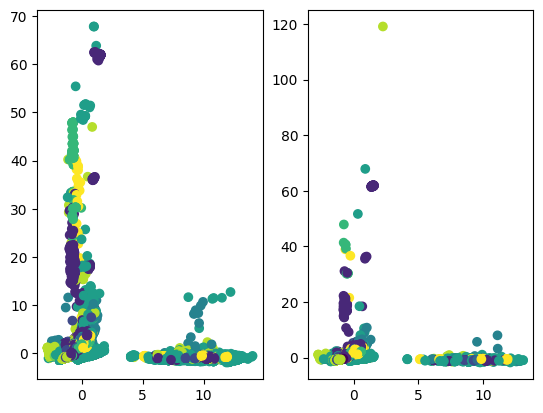

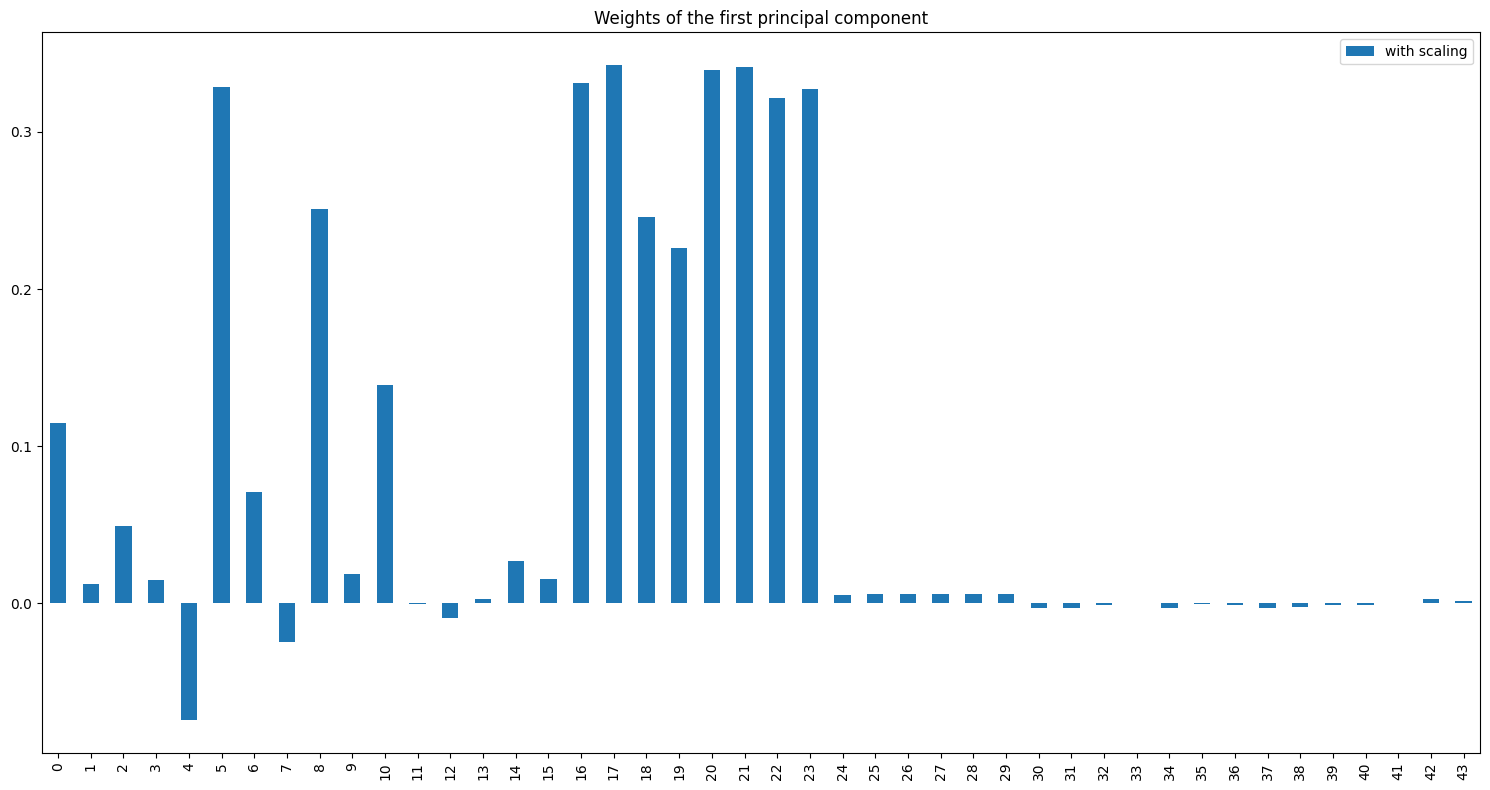

In [23]:
## PCA plotting
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)

axs[0].scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train)
axs[1].scatter(X_val_pca[:,0], X_val_pca[:,1], c=y_val)
plt.show()

first_pca_component = pd.DataFrame()
first_pca_component["with scaling"] = pca.components_[0]
first_pca_component.plot.bar(title="Weights of the first principal component", figsize=(15, 8))
_ = plt.tight_layout()

---

In [24]:
## WITH PCA

list_clf_pca = []
list_acc_train_pca = []
list_rec_train_pca = []
list_pre_train_pca = []
list_f1_train_pca = []

for k in [10,20,50,100,500,775,900,1000,1500,2000]:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train_pca, y_train)

    y_pred = clf.predict(X_test_pca)
    score_acc = accuracy_score(y_test, y_pred)
    list_acc_train_pca.append(score_acc)
    score_recall = recall_score(y_test, y_pred, average='weighted')
    list_rec_train_pca.append(score_recall)
    score_precision = precision_score(y_test, y_pred, average='weighted')
    list_pre_train_pca.append(score_precision)
    score_f1 = f1_score(y_test, y_pred, average='weighted')
    list_f1_train_pca.append(score_f1)

    score = clf.score(X_test_pca, y_test)

    print("K={:d}".format(k))
    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

    # if best_score < score:
    #     best_score = score
    #     best_k = k
    #     best_clf = clf
    
    list_clf_pca.append(clf)

K=10
  Accuracy - 0.9974
  F1 - 0.9974
K=20
  Accuracy - 0.9968
  F1 - 0.9968
K=50
  Accuracy - 0.9946
  F1 - 0.9946
K=100
  Accuracy - 0.9927
  F1 - 0.9927
K=500
  Accuracy - 0.9806
  F1 - 0.9800


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=775
  Accuracy - 0.9743
  F1 - 0.9732


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=900
  Accuracy - 0.9719
  F1 - 0.9706


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1000
  Accuracy - 0.9697
  F1 - 0.9683


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1500
  Accuracy - 0.9641
  F1 - 0.9620


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=2000
  Accuracy - 0.9524
  F1 - 0.9494


In [25]:

# file = pickle.load(open("knn_pca.pkl", "rb"))

# list_clf_pca = file[0]

list_acc_val_pca = []
list_rec_val_pca = []
list_pre_val_pca = []
list_f1_val_pca = []

for clf in list_clf_pca:
    val_pred = clf.predict(X_val_pca)

    score_acc = accuracy_score(y_val, val_pred)
    list_acc_val_pca.append(score_acc)
    score_recall = recall_score(y_val, val_pred, average='weighted')
    list_rec_val_pca.append(score_recall)
    score_precision = precision_score(y_val, val_pred, average='weighted')
    list_pre_val_pca.append(score_precision)
    score_f1 = f1_score(y_val, val_pred, average='weighted')
    list_f1_val_pca.append(score_f1)

    print(clf.n_neighbors)

    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

10
  Accuracy - 0.9969
  F1 - 0.9969
20
  Accuracy - 0.9962
  F1 - 0.9962
50
  Accuracy - 0.9940
  F1 - 0.9940
100
  Accuracy - 0.9924
  F1 - 0.9923
500
  Accuracy - 0.9797
  F1 - 0.9791


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


775
  Accuracy - 0.9726
  F1 - 0.9714


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


900
  Accuracy - 0.9702
  F1 - 0.9688


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1000
  Accuracy - 0.9681
  F1 - 0.9666


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1500
  Accuracy - 0.9624
  F1 - 0.9602
2000
  Accuracy - 0.9515
  F1 - 0.9483


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---

In [26]:
list_clf_lda = []
list_acc_train_lda = []
list_rec_train_lda = []
list_pre_train_lda = []
list_f1_train_lda = []

for k in [10,20,50,100,500,775,900,1000,1500,2000]:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train_lda, y_train)

    y_pred = clf.predict(X_test_lda)
    score_acc = accuracy_score(y_test, y_pred)
    list_acc_train_pca.append(score_acc)
    score_recall = recall_score(y_test, y_pred, average='weighted')
    list_rec_train_pca.append(score_recall)
    score_precision = precision_score(y_test, y_pred, average='weighted')
    list_pre_train_pca.append(score_precision)
    score_f1 = f1_score(y_test, y_pred, average='weighted')
    list_f1_train_pca.append(score_f1)

    score = clf.score(X_test_lda, y_test)

    print("K={:d}".format(k))
    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

    # if best_score < score:
    #     best_score = score
    #     best_k = k
    #     best_clf = clf
    
    list_clf_lda.append(clf)

K=10
  Accuracy - 0.9975
  F1 - 0.9975
K=20
  Accuracy - 0.9966
  F1 - 0.9966
K=50
  Accuracy - 0.9950
  F1 - 0.9949
K=100
  Accuracy - 0.9929
  F1 - 0.9929
K=500
  Accuracy - 0.9843
  F1 - 0.9840
K=775
  Accuracy - 0.9788
  F1 - 0.9783
K=900
  Accuracy - 0.9774
  F1 - 0.9765
K=1000
  Accuracy - 0.9762
  F1 - 0.9749


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1500
  Accuracy - 0.9701
  F1 - 0.9681


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=2000
  Accuracy - 0.9648
  F1 - 0.9625


In [27]:

# file = pickle.load(open("knn_pca.pkl", "rb"))

# list_clf_pca = file[0]

list_acc_val_lda = []
list_rec_val_lda = []
list_pre_val_lda = []
list_f1_val_lda = []

for clf in list_clf_lda:
    val_pred = clf.predict(X_val_lda)

    score_acc = accuracy_score(y_val, val_pred)
    list_acc_val_pca.append(score_acc)
    score_recall = recall_score(y_val, val_pred, average='weighted')
    list_rec_val_pca.append(score_recall)
    score_precision = precision_score(y_val, val_pred, average='weighted')
    list_pre_val_pca.append(score_precision)
    score_f1 = f1_score(y_val, val_pred, average='weighted')
    list_f1_val_pca.append(score_f1)

    print(clf.n_neighbors)

    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

10
  Accuracy - 0.9972
  F1 - 0.9972
20
  Accuracy - 0.9962
  F1 - 0.9962
50
  Accuracy - 0.9944
  F1 - 0.9944
100
  Accuracy - 0.9923
  F1 - 0.9923
500
  Accuracy - 0.9826
  F1 - 0.9822
775
  Accuracy - 0.9777
  F1 - 0.9771
900
  Accuracy - 0.9759
  F1 - 0.9750
1000
  Accuracy - 0.9747
  F1 - 0.9733


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1500
  Accuracy - 0.9689
  F1 - 0.9668
2000
  Accuracy - 0.9635
  F1 - 0.9610


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---

In [28]:
list_clf = []
list_acc_train = []
list_rec_train = []
list_pre_train = []
list_f1_train = []

for k in [10,20,50,100,500,775,900,1000,1500,2000]:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    score_acc = accuracy_score(y_test, y_pred)
    list_acc_train_pca.append(score_acc)
    score_recall = recall_score(y_test, y_pred, average='weighted')
    list_rec_train_pca.append(score_recall)
    score_precision = precision_score(y_test, y_pred, average='weighted')
    list_pre_train_pca.append(score_precision)
    score_f1 = f1_score(y_test, y_pred, average='weighted')
    list_f1_train_pca.append(score_f1)

    score = clf.score(X_test, y_test)

    print("K={:d}".format(k))
    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

    # if best_score < score:
    #     best_score = score
    #     best_k = k
    #     best_clf = clf
    
    list_clf.append(clf)

K=10
  Accuracy - 0.9974
  F1 - 0.9974
K=20
  Accuracy - 0.9968
  F1 - 0.9968
K=50
  Accuracy - 0.9946
  F1 - 0.9946
K=100
  Accuracy - 0.9927
  F1 - 0.9927
K=500
  Accuracy - 0.9806
  F1 - 0.9800


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=775
  Accuracy - 0.9743
  F1 - 0.9732


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=900
  Accuracy - 0.9719
  F1 - 0.9706


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1000
  Accuracy - 0.9697
  F1 - 0.9683


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1500
  Accuracy - 0.9641
  F1 - 0.9620


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=2000
  Accuracy - 0.9524
  F1 - 0.9494


In [29]:

# file = pickle.load(open("knn_pca.pkl", "rb"))

# list_clf_pca = file[0]

list_acc_val = []
list_rec_val = []
list_pre_val = []
list_f1_val = []

for clf in list_clf:
    val_pred = clf.predict(X_val)

    score_acc = accuracy_score(y_val, val_pred)
    list_acc_val_pca.append(score_acc)
    score_recall = recall_score(y_val, val_pred, average='weighted')
    list_rec_val_pca.append(score_recall)
    score_precision = precision_score(y_val, val_pred, average='weighted')
    list_pre_val_pca.append(score_precision)
    score_f1 = f1_score(y_val, val_pred, average='weighted')
    list_f1_val_pca.append(score_f1)

    print(clf.n_neighbors)

    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

10
  Accuracy - 0.9969
  F1 - 0.9969
20
  Accuracy - 0.9962
  F1 - 0.9962
50
  Accuracy - 0.9940
  F1 - 0.9940
100
  Accuracy - 0.9924
  F1 - 0.9923
500
  Accuracy - 0.9797
  F1 - 0.9791


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


775
  Accuracy - 0.9726
  F1 - 0.9714


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


900
  Accuracy - 0.9702
  F1 - 0.9688


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1000
  Accuracy - 0.9681
  F1 - 0.9666


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1500
  Accuracy - 0.9624
  F1 - 0.9602
2000
  Accuracy - 0.9515
  F1 - 0.9483


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
with open('knn_lda_1.pkl', 'wb') as f:
    pickle.dump([list_clf_lda, list_acc_train_lda, list_rec_train_lda, list_pre_train_lda, list_f1_train_lda, list_acc_val_lda, list_rec_val_lda, list_pre_val_lda, list_f1_val_lda], f)
with open('knn_pca_1.pkl', 'wb') as f:
    pickle.dump([list_clf_pca, list_acc_train_pca, list_rec_train_pca, list_pre_train_pca, list_f1_train_pca, list_acc_val_pca, list_rec_val_pca, list_pre_val_pca, list_f1_val_pca], f)
with open('knn_std_1.pkl', 'wb') as f:
    pickle.dump([list_clf, list_acc_train, list_rec_train, list_pre_train, list_f1_train, list_acc_val, list_rec_val, list_pre_val, list_f1_val], f)